# Model Input

In [9]:
import numpy
numpy.random.seed(100)

import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools

import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, Reshape, LSTM, GRU
from keras.regularizers import l1

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from Plot_CM import plot_confusion_matrix
import pickle

print('Loading Data..')
X_train = numpy.load('/Users/92306/Documents/Train_Data_S.npy')
X_test = numpy.load('/Users/92306/Documents/Test_Data_S.npy')
X_valid = numpy.load('/Users/92306/Documents/Valid_Data_S.npy')
y_train = numpy.load('/Users/92306/Documents/Train_Label_S.npy')
y_test = numpy.load('/Users/92306/Documents/Test_Label_S.npy')
y_valid = numpy.load('/Users/92306/Documents/Valid_Label_S.npy')

print('Reshaping the Data that fit the model..')
X_train = numpy.squeeze(numpy.stack((X_train,) * 3, -1))
X_test = numpy.squeeze(numpy.stack((X_test,) * 3, -1))
X_valid = numpy.squeeze(numpy.stack((X_valid,) * 3, -1))


print('Train Data:{0}, Test Data:{1}, Valid Data:{2}'.format(X_train.shape,X_test.shape,X_valid.shape))
print('Train Label:{0}, Test Label:{1}, Valid Label:{2}'.format(y_train.shape,y_test.shape,y_valid.shape))


input_shape = X_train[0].shape
num_genres = 10

print('Input Shape:{0}'.format(input_shape))
print('Number of genres:{0}'.format(num_genres))


Loading Data..
Reshaping the Data that fit the model..
Train Data:(13338, 513, 129, 3), Test Data:(1900, 513, 129, 3), Valid Data:(3762, 513, 129, 3)
Train Label:(13338, 10), Test Label:(1900, 10), Valid Label:(3762, 10)
Input Shape:(513, 129, 3)
Number of genres:10


# Model Training

In [11]:
model = Sequential()
# Conv Block 1
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.25))

# Conv Block 4
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.25))

# Conv Block 5
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu',	padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.25))

# LSTM Block
model.add(Reshape((16,64)))
model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=(8,128)))
model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(units=32, kernel_regularizer=l1(0.01), activation='relu'))
model.add(Dense(units=10, activation='softmax', kernel_regularizer=l1(0.01)))

# MLP
# model.add(Flatten())
# model.add(Dense(num_genres, activation='softmax'))

print('Summary..')
model.summary()

print('Compiling Model')
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

print('Fitting Model')
hist = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_valid, y_valid), shuffle=False)

## Change the filename ##
print('Saving hist model into cnn_lstm_s.pickle')
with open('cnn_lstm_s.pickle','wb') as f:
	pickle.dump(hist.history, f)

model.save('Model_CNN_LSTM_S.h5')
####################################

Summary..
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 511, 127, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 256, 64, 16)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256, 64, 16)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 254, 62, 32)       4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 31, 32)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 127, 31, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 127, 31,

# Model Results

Test_loss = 1.114 and Test_acc = 0.786


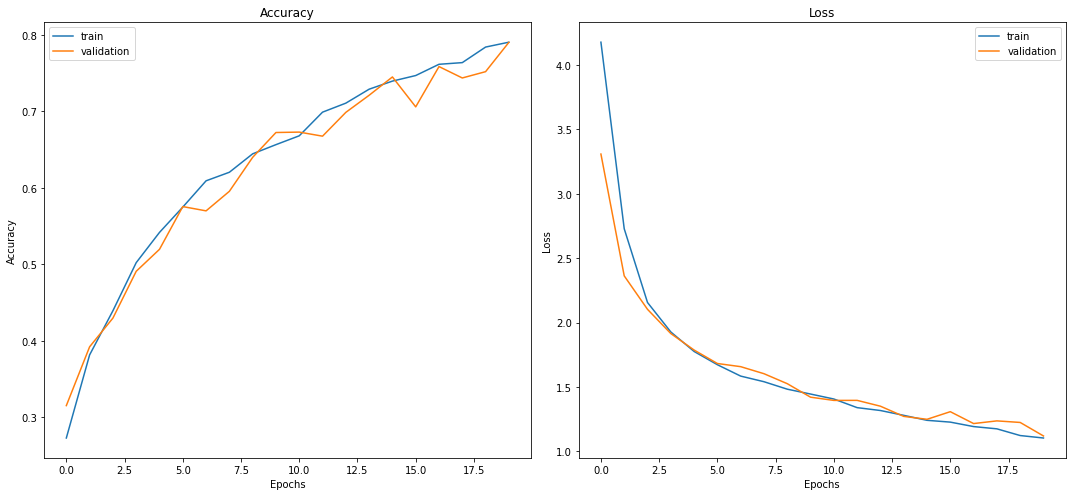

Confusion Matrix Calculating..
Normalized confusion matrix


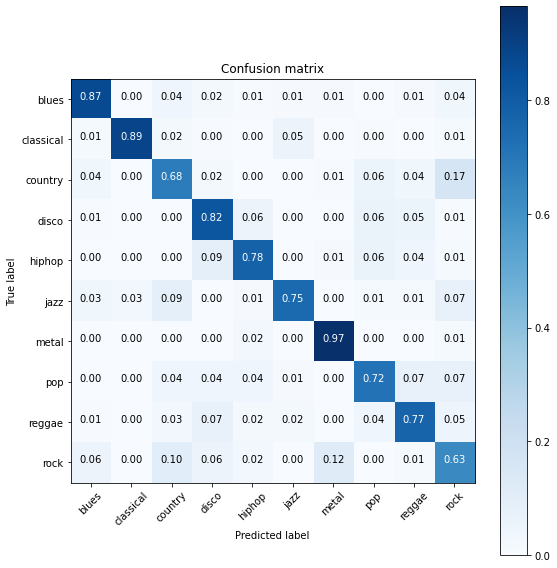

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
score = model.evaluate(X_test, y_test, verbose=0)
print("Test_loss = {:.3f} and Test_acc = {:.3f}".format(score[0], score[1]))


# Plotting
plt.figure(figsize=(15,7))


plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



print('Confusion Matrix Calculating..')
preds = numpy.argmax(model.predict(X_test), axis = 1)
y_orig = numpy.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)
plt.show()
